<a href="https://colab.research.google.com/github/Verona1901/A_B_test/blob/main/dz9_A_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Урок 9. Python применение продвинутых методов
Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.

Mobile Games AB Testing with Cookie Cats

In [60]:
import pandas as pd
from statsmodels.stats import proportion
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
import numpy as np

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

In [4]:
df = pd.read_csv('результаты А_B - cookie_cats 2.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1


In [5]:
df.describe()

,userid,sum_gamerounds,retention_1,retention_7
count,9.018900e+04,90189.000000,90189.000000,90189.000000
mean,4.998412e+06,51.872457,0.445210,0.186065
std,2.883286e+06,195.050858,0.496992,0.389161
min,1.160000e+02,0.000000,0.000000,0.000000
25%,2.512230e+06,5.000000,0.000000,0.000000
50%,4.995815e+06,16.000000,0.000000,0.000000
75%,7.496452e+06,51.000000,1.000000,0.000000
max,9.999861e+06,49854.000000,1.000000,1.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  int64 
 4   retention_7     90189 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 3.4+ MB


Подсчет количества игроков в каждой группе

In [7]:
df.groupby("version")[["userid"]].nunique()

,userid
version,
gate_30,44700
gate_40,45489


Распределение игроков в группе примерно одинаковое.

Проверка на пропуски

In [9]:
df.isna().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

Удержание в течении 1 дня после установки

In [10]:
df.retention_1.value_counts()

0    50036
1    40153
Name: retention_1, dtype: int64

Удержание в течении 7 дней после установки

In [11]:
df.retention_7.value_counts()

0    73408
1    16781
Name: retention_7, dtype: int64

Проверка нормальности распределения

Группа gate_30

In [13]:
test_stat, pvalue = shapiro(df.loc[df["version"] == "gate_30", "sum_gamerounds"])
print("Test Stat = %.4f, p-value = %.4f" % (test_stat, pvalue))

Test Stat = 0.0881, p-value = 0.0000


In [16]:
alpha = 0.05

st = shapiro(df.loc[df["version"] == "gate_30", "sum_gamerounds"])
print('Discription is {}normal\n'.format( {True: 'not ',
False: ''}[st[1] < alpha]));

Discription is not normal



Группа gate_40

In [14]:
test_stat, pvalue = shapiro(df.loc[df["version"] == "gate_40", "sum_gamerounds"])
print("Test Stat = %.4f, p-value = %.4f" % (test_stat, pvalue))

Test Stat = 0.4826, p-value = 0.0000


In [17]:
alpha = 0.05

st = shapiro(df.loc[df["version"] == "gate_40", "sum_gamerounds"])
print('Discription is {}normal\n'.format( {True: 'not ',
False: ''}[st[1] < alpha]));

Discription is not normal



p-value < 0.05

Выборки обеих групп не подчиняются нормальному закону.

 График распределения количества игровых раундов, сыгранных игроками в течение их первой недели игры.

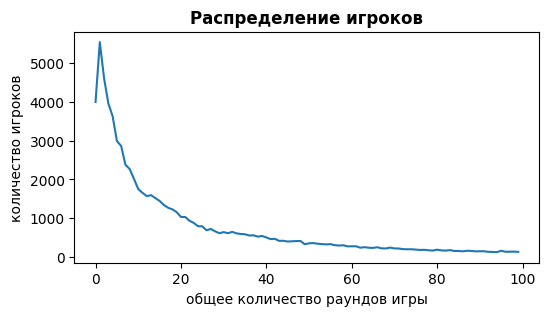

In [41]:
plt.figure(figsize=(6, 3))
plot_df = df.groupby("sum_gamerounds")["userid"].count()

ax = plot_df.head(100).plot()
plt.title("Распределение игроков", fontweight="bold", size=12)
plt.xlabel("общее количество раундов игры", size=10)
plt.ylabel("количество игроков", size=10)
plt.show()

Некоторые игроки устанавливают игру, но никогда в нее не играют (0 игровых раундов). Выясним, сколько их всего:

In [48]:
df[df["sum_gamerounds"]== 0]["userid"].count()

3994

Рассчитаем процент удержания после 1 дня установки и через 7 дней.

In [49]:
df_retention = df[["retention_1","retention_7"]].mean()*100
print(f"1-день: {round(df_retention[0],2)}% \
      \n7-дней: {round(df_retention[1],2)}%")

1-день: 44.52%       
7-дней: 18.61%


Различие показателей удержания в двух группах A / B:

In [50]:
df_retention_ab = df.groupby("version").agg({"userid":"count", "retention_1":"mean","retention_7":"mean", "sum_gamerounds":"sum"})
df_retention_ab

,userid,retention_1,retention_7,sum_gamerounds
version,,,,
gate_30,44700,0.448188,0.190201,2344795
gate_40,45489,0.442283,0.182000,2333530


Процент удержания через 7 дней несколько выше у gate_30.

Проведем bootstrap-анализ.

In [47]:
boot_1d = []
boot_7d = []
for i in range(500):
    boot_mean_1 = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    boot_mean_7 = df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_1d.append(boot_mean_1)
    boot_7d.append(boot_mean_7)

# Transforming the list to a DataFrame
boot_1d = pd.DataFrame(boot_1d)
boot_7d = pd.DataFrame(boot_7d)

print(boot_1d.head())
print(boot_7d.head())

version       gate_30   gate_40
retention_1  0.445234  0.439392
retention_1  0.451054  0.441785
retention_1  0.449867  0.442383
retention_1  0.450425  0.441470
retention_1  0.446716  0.445641
version       gate_30   gate_40
retention_7  0.190071  0.179698
retention_7  0.190534  0.176277
retention_7  0.192564  0.181820
retention_7  0.190620  0.181546
retention_7  0.191724  0.181502


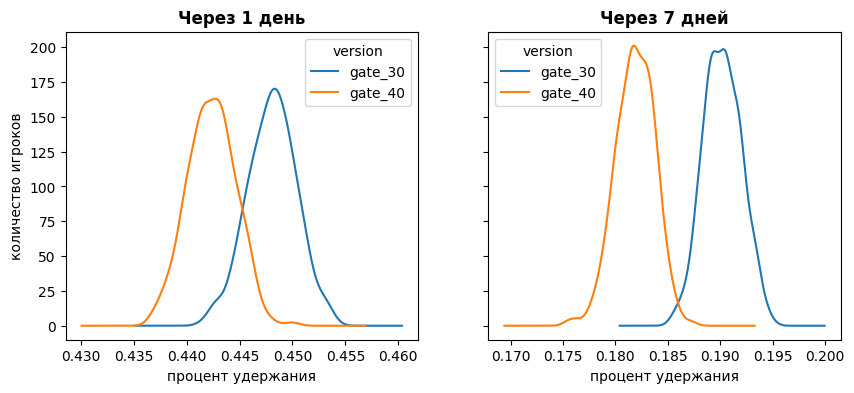

In [57]:
fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,4))

boot_1d.plot.kde(ax=ax1)
ax1.set_xlabel("процент удержания",size=10)
ax1.set_ylabel("количество игроков",size=10)
ax1.set_title("Через 1 день", fontweight="bold",size=12)

boot_7d.plot.kde(ax=ax2)
ax2.set_xlabel("процент удержания",size=10)
ax2.set_ylabel("количество игроков",size=10)
ax2.set_title("Через 7 дней", fontweight="bold",size=12)
plt.show()

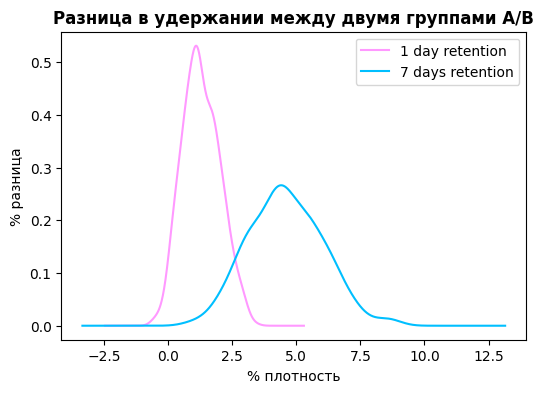

In [62]:
# Adding a column with the % difference between the two A/B groups
boot_1d['diff'] = ((boot_1d['gate_30'] - boot_1d['gate_40']) / boot_1d['gate_40'] * 100)
boot_7d['diff'] = ((boot_7d['gate_30'] - boot_7d['gate_40']) / boot_7d['gate_40'] * 100)

# Ploting the bootstrap % difference
fig, (ax1) = plt.subplots(1, 1,figsize=(6,4))

boot_1d['diff'].plot.kde(ax=ax1, c="#ff99ff", label = "1 day retention")
boot_7d['diff'].plot.kde(ax=ax1, c= "#00bfff", label = "7 days retention")
ax1.set_xlabel("% плотность",size=10)
ax1.set_ylabel("% разница",size=10)
ax1.set_title("Разница в удержании между двумя группами A/B", fontweight="bold", size=12)
plt.legend()
plt.show()

Применим Критерий Манна-Уитни для оценки различий двух групп:

In [61]:
test_stat, pvalue = mannwhitneyu(df.loc[df["version"] == "gate_30", "sum_gamerounds"],
                            df.loc[df["version"] == "gate_40", "sum_gamerounds"])
print("Test Stat = %.4f, p-value = %.4f" % (test_stat, pvalue))

Test Stat = 1024331250.5000, p-value = 0.0502


Так как p-value > 0.05 то принимаем нулевую гипотезу о равенстве средних значений двух выборок. (т.е. между gate_30 и gate_40 - статистически значимых различий нет)

Исходя из результатов эксперимента, можно предположить, что наблюдаемые различия между группами случайны.

Рекомендация для менеджера - продолжать мониторить результаты и провести дополнительные эксперименты.